In [6]:
from scipy.stats import expon,gamma
from numpy.random import seed
import pymc3 as pm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Processed_data/full_clean_data.csv',index_col=0)

In [17]:
amount = df.amount.dropna()

In [26]:
amount.shape

(663623,)

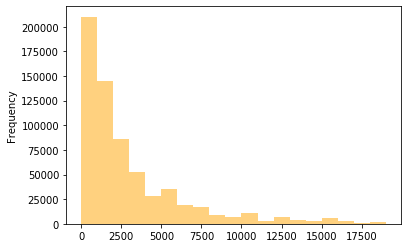

In [18]:
amount.plot.hist(bins=range(0,20000,1000),label='observed',alpha=0.5,color='orange')

## Exponential distribution simulation

$f(x) = \lambda e^{-\lambda x}$ (x > 0)

In [20]:
mean = amount.mean() # mean = 1/lambda = scale
sd = amount.std()

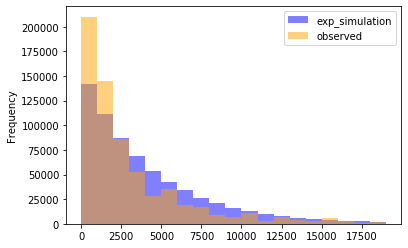

In [31]:
from numpy.random import exponential
exp = exponential(scale=mean,size=amount.shape[0])
plt.hist(exp, bins=range(0,20000,1000),label='exp_simulation',alpha=0.5,color='blue')
amount.plot.hist(bins=range(0,20000,1000),label='observed',alpha=0.5,color='orange')
plt.legend()

In [72]:
# use normal distribution as prior guess of distribution
with pm.Model() as model:
    mu_ = pm.Normal('mu', mu = mean, sigma=mean)
    y_obs = pm.Exponential('y_obs', lam = 1/mu_, observed=amount)
    trace = pm.sample(tune = 2000,chains=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [mu]
Sampling 3 chains: 100%|██████████| 7500/7500 [01:44<00:00, 71.89draws/s]


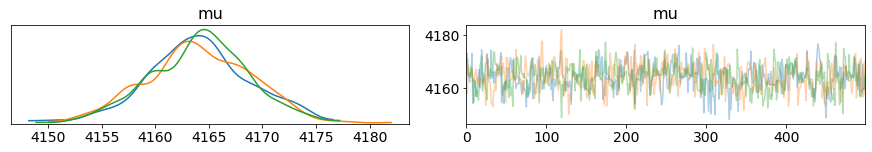

In [73]:
_ = pm.traceplot(trace)

In [92]:
np.mean(trace['mu']), mean

(4164.025085714386, 4163.748763756221)

Text(0.5, 1.0, 'Frequentist Inference')

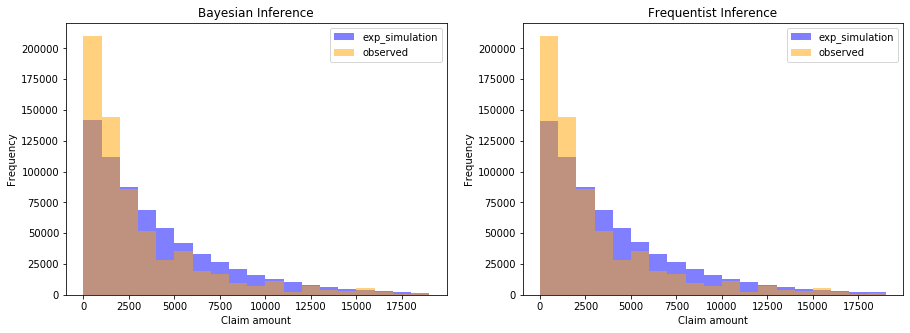

In [85]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
exp = exponential(scale=4165,size=amount.shape[0])
ax1.hist(exp, bins=range(0,20000,1000),label='exp_simulation',alpha=0.5,color='blue')
amount.plot.hist(bins=range(0,20000,1000),label='observed',alpha=0.5,color='orange',ax=ax1)
plt.legend()
plt.xlabel('Claim amount')
plt.title('Bayesian Inference')

ax2 = fig.add_subplot(122)
exp = exponential(scale=mean,size=amount.shape[0])
ax2.hist(exp, bins=range(0,20000,1000),label='exp_simulation',alpha=0.5,color='blue')
amount.plot.hist(bins=range(0,20000,1000),label='observed',alpha=0.5,color='orange',ax=ax2)
plt.legend()
plt.xlabel('Claim amount')
plt.title('Frequentist Inference')

## Gamma distribution simulation

$p(x) = x^{k-1}\frac{e^{-x/\theta}}{\theta^k\Gamma(k)},   x>0,   \Gamma(k) = (k-1)!$

$\mu = k\theta, \sigma^2 = k{\theta}^2$

$k= {\mu}^2/\sigma^2, \theta = \sigma^2/\mu$

In [110]:
# initial parameter of gamma distribution mean = k
k = (mean/sd)**2 # shape parameter, also called alpha
theta = sd**2/mean # scale parameter, also called 1/beta
k,theta, 1/theta

(0.04847690166421654, 85891.39612504799, 1.1642609680533252e-05)

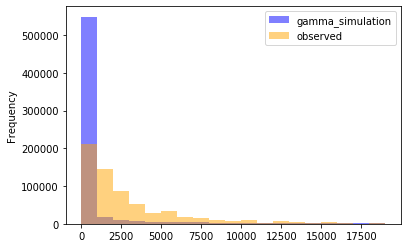

In [112]:
from numpy.random import gamma

gamma_simulation = gamma(shape=k, scale=theta,size=amount.shape[0])
plt.hist(gamma_simulation, bins=range(0,20000,1000),label='gamma_simulation',alpha=0.5,color='blue')
amount.plot.hist(bins=range(0,20000,1000),label='observed',alpha=0.5,color='orange')
plt.legend()

## Baysian Modeling with Monte Carlo Markov Chain

### Exponential distribution

In [123]:
# observation (obs)
obs = amount.loc[amount>0]
obs.mean(),amount.mean()

(4164.878438464487, 4163.748763756221)

In [124]:

# baysian optimization of parameter
with pm.Model() as model:
    
    alpha_ = pm.Exponential('alpha', k)
    rate_ = pm.Exponential('rate',1/theta)
    
    y_obs = pm.Gamma('y_obs', alpha=alpha_, beta=1/rate_, observed=obs)
    trace = pm.sample(tune = 2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rate, alpha]
Sampling 2 chains: 100%|██████████| 5000/5000 [03:29<00:00, 23.84draws/s]  


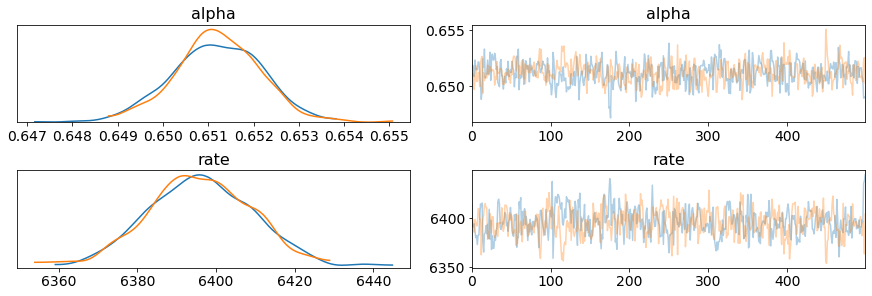

In [125]:
_ = pm.traceplot(trace)

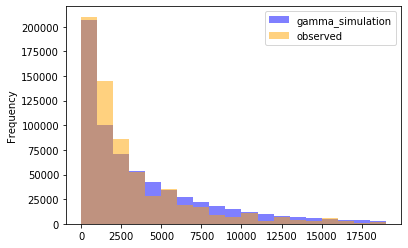

In [126]:
gamma_simulation = gamma(shape=0.651, scale=6390,size=amount.shape[0])
plt.hist(gamma_simulation, bins=range(0,20000,1000),label='gamma_simulation',alpha=0.5,color='blue')
amount.plot.hist(bins=range(0,20000,1000),label='observed',alpha=0.5,color='orange')
plt.legend()